In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv
/kaggle/input/unsw-nb15/UNSW-NB15_1.csv
/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv
/kaggle/input/unsw-nb15/UNSW-NB15_LIST_EVENTS.csv
/kaggle/input/unsw-nb15/UNSW-NB15_4.csv
/kaggle/input/unsw-nb15/UNSW-NB15_3.csv
/kaggle/input/unsw-nb15/UNSW-NB15_2.csv
/kaggle/input/unsw-nb15/NUSW-NB15_features.csv


In [52]:
import pandas as pd
import numpy as np
import sys
import keras
import sklearn
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
import sklearn.preprocessing
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.utils import get_file, plot_model
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [53]:
#Loading training set into dataframe
df = pd.read_csv('../input/unsw-nb15/UNSW_NB15_testing-set.csv')
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [54]:
#Loading testing set into dataframe
qp = pd.read_csv('../input/unsw-nb15/UNSW_NB15_training-set.csv')
qp.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [55]:
qp['attack_cat'].value_counts()

Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: attack_cat, dtype: int64

In [56]:
df['attack_cat'].value_counts()

Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64

In [57]:
df = df.drop('id', 1) 
df.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


(175341, 44)

In [58]:
df = df.drop('label', 1) 
df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,Normal


In [59]:
qp = qp.drop('id', 1)
qp = qp.drop('label', 1)
qp.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


(82332, 43)

In [60]:
df.isnull().sum()

dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat           0
dtype: int6

In [61]:
qp.isnull().sum()

dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat           0
dtype: int6

In [62]:
# We do not have missing values and do not have to deal with it
#defining col list
cols = ['proto','state','service']
cols

['proto', 'state', 'service']

In [63]:
#One-hot encoding for the categorical features
def one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(each, 1)
    return df

In [64]:
#Merging train and test data
combined_data = pd.concat([df,qp])
combined_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,...,1,1,2,0,0,0,2,1,0,Normal
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,...,1,1,1,0,0,0,3,2,0,Normal
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal


In [65]:
combined_data

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,1,0,0,0,1,1,0,Normal
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,1,2,0,0,0,1,6,0,Normal
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,1,3,0,0,0,2,6,0,Normal
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,1,3,1,1,0,2,1,0,Normal
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,2,1,40,0,0,0,2,39,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,...,1,1,2,0,0,0,2,1,0,Normal
82328,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,...,1,1,1,0,0,0,3,2,0,Normal
82329,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal
82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,...,1,1,1,0,0,0,1,1,1,Normal


In [66]:
tmp = combined_data.pop('attack_cat')

In [67]:
#Applying one hot encoding to combined data
combined_data = one_hot(combined_data,cols)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [68]:
combined_data

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl
0,0.121478,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,...,0,0,0,0,0,0,0,0,0,0
1,0.649902,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,...,0,0,0,0,0,0,0,0,0,0
2,1.623129,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,...,0,0,0,0,0,0,0,0,0,0
3,1.681642,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,...,1,0,0,0,0,0,0,0,0,0
4,0.449454,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,0.000005,2,0,104,0,200000.005100,254,0,8.320000e+07,0.000000,...,0,0,0,0,0,0,0,0,0,0
82328,1.106101,20,8,18062,354,24.410067,254,252,1.241044e+05,2242.109863,...,0,0,0,0,0,0,0,0,0,0
82329,0.000000,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,...,0,0,0,0,0,0,0,0,0,0
82330,0.000000,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [69]:
#Function to min-max normalize
def normalize(df, cols):
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [70]:
#Normalizing training set
new_train_df = normalize(combined_data,combined_data.columns)
new_train_df.shape

(257673, 196)

In [71]:
tmp.value_counts()['Normal']

93000

In [72]:
#Appending class column to training set
new_train_df["Class"] = tmp
new_train_df.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


(257673, 197)

In [73]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [74]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [75]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

final_train_df = new_train_df[new_train_df['Class'].isin(['Normal', 'Generic', 'Exploits'])]

lowClasses = [ 'Fuzzers', 'DoS', 'Reconnaissance', 'Backdoor', 'Shellcode','Analysis']
for cat in lowClasses:
    newer_train_df = new_train_df[new_train_df['Class'].isin([cat])]
    newest_train_df = newer_train_df.drop('Class', axis=1)
    
    latent_dim = 20

    encoder_inputs = keras.Input(shape=(196, 1))
    x = layers.Convolution1D(64, kernel_size=64, padding="same",activation="tanh",input_shape=(196, 1))(encoder_inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="tanh")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(196 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((196,64))(x)
    x = layers.Conv1DTranspose(64, kernel_size=64, padding="same",activation="tanh")(x)
    decoder_outputs = layers.Conv1DTranspose(1,64, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    
    x_train, x_test = train_test_split(newest_train_df, test_size=0.2)
    mnist_digits = np.concatenate([x_train, x_test], axis=0)
    mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
    
    print("VAEs for " + cat)
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.fit(mnist_digits, epochs=20, batch_size=128)
    
    for i in tqdm(range(30000 - tmp.value_counts()[cat])):
        z_sample = np.array([np.random.uniform(low=-1, high=1, size=(latent_dim,))])
        x_decoded = vae.decoder.predict(z_sample)

        x_decoded = np.array([x_decoded[0][i][0] for i in range(196)])
        newest_train_df = newest_train_df.append(pd.DataFrame(x_decoded.reshape(1,-1), columns=list(newest_train_df)), ignore_index=True)
        
    newest_train_df['Class'] = [cat for i in range(30000)]

    final_train_df = pd.concat([final_train_df, newest_train_df])
    print(newer_train_df['Class'].value_counts()[cat])

newer_train_df

VAEs for Fuzzers
Epoch 1/20
190/190 [==============================] - 3s 14ms/step - loss: 7.2967 - reconstruction_loss: 1.8187 - kl_loss: 0.0166
Epoch 2/20
190/190 [==============================] - 3s 14ms/step - loss: 0.3398 - reconstruction_loss: 0.3218 - kl_loss: 7.3076e-05
Epoch 3/20
190/190 [==============================] - 3s 14ms/step - loss: 0.2941 - reconstruction_loss: 0.2886 - kl_loss: 1.4749e-05
Epoch 4/20
190/190 [==============================] - 3s 14ms/step - loss: 0.2761 - reconstruction_loss: 0.2729 - kl_loss: 1.0284e-05
Epoch 5/20
190/190 [==============================] - 3s 14ms/step - loss: 0.2642 - reconstruction_loss: 0.2614 - kl_loss: 8.5556e-06
Epoch 6/20
190/190 [==============================] - 3s 14ms/step - loss: 0.2527 - reconstruction_loss: 0.2495 - kl_loss: 8.2191e-06
Epoch 7/20
190/190 [==============================] - 3s 14ms/step - loss: 0.2411 - reconstruction_loss: 0.2382 - kl_loss: 7.0731e-06
Epoch 8/20
190/190 [=============================

100%|██████████| 5754/5754 [05:00<00:00, 19.18it/s]


24246
VAEs for DoS
Epoch 1/20
128/128 [==============================] - 3s 14ms/step - loss: 9.4202 - reconstruction_loss: 2.3094 - kl_loss: 0.0193
Epoch 2/20
128/128 [==============================] - 2s 14ms/step - loss: 0.3717 - reconstruction_loss: 0.3252 - kl_loss: 5.0060e-04
Epoch 3/20
128/128 [==============================] - 2s 14ms/step - loss: 0.2538 - reconstruction_loss: 0.2495 - kl_loss: 1.1826e-05
Epoch 4/20
128/128 [==============================] - 2s 14ms/step - loss: 0.2393 - reconstruction_loss: 0.2367 - kl_loss: 8.9039e-06
Epoch 5/20
128/128 [==============================] - 2s 14ms/step - loss: 0.2290 - reconstruction_loss: 0.2280 - kl_loss: 7.0017e-06
Epoch 6/20
128/128 [==============================] - 2s 14ms/step - loss: 0.2230 - reconstruction_loss: 0.2217 - kl_loss: 5.3312e-06
Epoch 7/20
128/128 [==============================] - 2s 14ms/step - loss: 0.2178 - reconstruction_loss: 0.2163 - kl_loss: 4.0058e-06
Epoch 8/20
128/128 [===========================

100%|██████████| 13647/13647 [11:19<00:00, 20.07it/s]


16353
VAEs for Reconnaissance
Epoch 1/20
110/110 [==============================] - 2s 14ms/step - loss: 10.3607 - reconstruction_loss: 2.6219 - kl_loss: 0.0200
Epoch 2/20
110/110 [==============================] - 2s 14ms/step - loss: 0.4474 - reconstruction_loss: 0.3900 - kl_loss: 0.0011
Epoch 3/20
110/110 [==============================] - 2s 14ms/step - loss: 0.2942 - reconstruction_loss: 0.2856 - kl_loss: 4.4810e-05
Epoch 4/20
110/110 [==============================] - 2s 14ms/step - loss: 0.2708 - reconstruction_loss: 0.2681 - kl_loss: 1.4372e-05
Epoch 5/20
110/110 [==============================] - 2s 14ms/step - loss: 0.2585 - reconstruction_loss: 0.2568 - kl_loss: 1.3137e-05
Epoch 6/20
110/110 [==============================] - 2s 14ms/step - loss: 0.2515 - reconstruction_loss: 0.2490 - kl_loss: 1.1537e-05
Epoch 7/20
110/110 [==============================] - 2s 14ms/step - loss: 0.2438 - reconstruction_loss: 0.2428 - kl_loss: 9.5391e-06
Epoch 8/20
110/110 [===================

100%|██████████| 16013/16013 [12:58<00:00, 20.57it/s]


13987
VAEs for Backdoor
Epoch 1/20
19/19 [==============================] - 1s 14ms/step - loss: 38.8306 - reconstruction_loss: 13.5502 - kl_loss: 0.0639
Epoch 2/20
19/19 [==============================] - 0s 13ms/step - loss: 0.5151 - reconstruction_loss: 0.5251 - kl_loss: 0.0096
Epoch 3/20
19/19 [==============================] - 0s 13ms/step - loss: 0.5609 - reconstruction_loss: 0.5617 - kl_loss: 0.0011
Epoch 4/20
19/19 [==============================] - 0s 13ms/step - loss: 0.5504 - reconstruction_loss: 0.5411 - kl_loss: 8.0007e-04
Epoch 5/20
19/19 [==============================] - 0s 13ms/step - loss: 0.5247 - reconstruction_loss: 0.5155 - kl_loss: 5.8224e-04
Epoch 6/20
19/19 [==============================] - 0s 13ms/step - loss: 0.4930 - reconstruction_loss: 0.4829 - kl_loss: 6.8819e-04
Epoch 7/20
19/19 [==============================] - 0s 13ms/step - loss: 0.4555 - reconstruction_loss: 0.4479 - kl_loss: 7.4040e-04
Epoch 8/20
19/19 [==============================] - 0s 14ms/st

100%|██████████| 27671/27671 [20:24<00:00, 22.59it/s]


2329
VAEs for Shellcode
Epoch 1/20
12/12 [==============================] - 1s 20ms/step - loss: 51.6506 - reconstruction_loss: 21.3245 - kl_loss: 0.1070
Epoch 2/20
12/12 [==============================] - 0s 14ms/step - loss: 0.4714 - reconstruction_loss: 0.4946 - kl_loss: 0.0257
Epoch 3/20
12/12 [==============================] - 0s 14ms/step - loss: 0.6005 - reconstruction_loss: 0.6023 - kl_loss: 0.0082
Epoch 4/20
12/12 [==============================] - 0s 14ms/step - loss: 0.6277 - reconstruction_loss: 0.6268 - kl_loss: 0.0018
Epoch 5/20
12/12 [==============================] - 0s 14ms/step - loss: 0.6278 - reconstruction_loss: 0.6198 - kl_loss: 8.6566e-04
Epoch 6/20
12/12 [==============================] - 0s 14ms/step - loss: 0.6086 - reconstruction_loss: 0.6006 - kl_loss: 6.6807e-04
Epoch 7/20
12/12 [==============================] - 0s 14ms/step - loss: 0.5815 - reconstruction_loss: 0.5740 - kl_loss: 8.3065e-04
Epoch 8/20
12/12 [==============================] - 0s 14ms/step -

100%|██████████| 28489/28489 [20:56<00:00, 22.68it/s]


1511
VAEs for Analysis
Epoch 1/20
21/21 [==============================] - 1s 17ms/step - loss: 34.0736 - reconstruction_loss: 11.3923 - kl_loss: 0.1018
Epoch 2/20
21/21 [==============================] - 0s 14ms/step - loss: 0.5504 - reconstruction_loss: 0.5586 - kl_loss: 0.0085
Epoch 3/20
21/21 [==============================] - 0s 14ms/step - loss: 0.5763 - reconstruction_loss: 0.5747 - kl_loss: 0.0015
Epoch 4/20
21/21 [==============================] - 0s 14ms/step - loss: 0.5588 - reconstruction_loss: 0.5464 - kl_loss: 0.0011
Epoch 5/20
21/21 [==============================] - 0s 14ms/step - loss: 0.5208 - reconstruction_loss: 0.5077 - kl_loss: 9.9388e-04
Epoch 6/20
21/21 [==============================] - 0s 14ms/step - loss: 0.4796 - reconstruction_loss: 0.4653 - kl_loss: 0.0012
Epoch 7/20
21/21 [==============================] - 0s 14ms/step - loss: 0.4338 - reconstruction_loss: 0.4243 - kl_loss: 0.0013
Epoch 8/20
21/21 [==============================] - 0s 14ms/step - loss: 0.

100%|██████████| 27323/27323 [20:22<00:00, 22.35it/s]


2677


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl,Class
47932,1.500000e-07,0.000094,0.000000,0.000012,0.000000,1.111111e-01,0.996078,0.000000,1.484450e-02,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Analysis
47936,1.500000e-07,0.000094,0.000000,0.000012,0.000000,1.111111e-01,0.996078,0.000000,1.484450e-02,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Analysis
47938,1.333334e-07,0.000094,0.000000,0.000012,0.000000,1.250000e-01,0.996078,0.000000,1.670007e-02,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Analysis
47940,1.333334e-07,0.000094,0.000000,0.000012,0.000000,1.250000e-01,0.996078,0.000000,1.670007e-02,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Analysis
47941,1.333334e-07,0.000094,0.000000,0.000012,0.000000,1.250000e-01,0.996078,0.000000,1.670007e-02,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Analysis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65648,1.084275e-02,0.000845,0.000908,0.000055,0.000082,2.920538e-05,0.243137,0.992126,1.495026e-06,0.000591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Analysis
65650,1.037122e-02,0.000845,0.000726,0.000055,0.000073,2.731920e-05,0.243137,0.992126,1.584468e-06,0.000539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Analysis
65651,7.693251e-03,0.000845,0.000726,0.000056,0.000093,3.682882e-05,0.243137,0.992126,2.141799e-06,0.000924,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Analysis
65703,6.666668e-08,0.000094,0.000000,0.000012,0.000000,9.090909e-02,0.996078,0.000000,1.214550e-02,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Analysis


In [76]:
final_train_df['Class'].value_counts()

Normal            93000
Generic           58871
Exploits          44525
Fuzzers           30000
DoS               30000
Reconnaissance    30000
Backdoor          30000
Shellcode         30000
Analysis          30000
Name: Class, dtype: int64

In [77]:
final_train_df.isnull().values.any()

False

In [78]:
#y_train=new_train_df["Class"]
y_train=final_train_df["Class"]

y_train

0          Normal
1          Normal
2          Normal
3          Normal
4          Normal
           ...   
29995    Analysis
29996    Analysis
29997    Analysis
29998    Analysis
29999    Analysis
Name: Class, Length: 376396, dtype: object

In [79]:
y_train.isnull().values.any()

False

In [80]:
#combined_data_X = new_train_df.drop('Class', 1)
combined_data_X = final_train_df.drop('Class', 1)

combined_data_X

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_ftp,service_ftp-data,service_http,service_irc,service_pop3,service_radius,service_smtp,service_snmp,service_ssh,service_ssl
0,0.002025,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.010832,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.992126,1.401989e-06,0.022458,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.027052,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.028027,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.007491,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.015517,0.012821,0.010597,0.009755,0.008628,0.008172,0.007665,0.006626,5.357611e-03,0.004992,...,0.004974,0.005245,0.006301,0.006936,0.007612,0.007874,0.008674,0.010513,0.012866,0.015323
29996,0.007221,0.006224,0.005156,0.004799,0.003985,0.003852,0.003545,0.003141,2.508316e-03,0.002367,...,0.002516,0.002597,0.003182,0.003454,0.003819,0.004245,0.004608,0.005601,0.007040,0.008734
29997,0.014438,0.012390,0.010591,0.009725,0.008644,0.008269,0.007808,0.006840,5.519433e-03,0.005168,...,0.005329,0.005387,0.006576,0.007138,0.007528,0.007854,0.008849,0.010599,0.012447,0.014992
29998,0.012777,0.011384,0.009475,0.008664,0.007664,0.007647,0.007152,0.006295,5.138975e-03,0.004695,...,0.004425,0.004825,0.005515,0.005980,0.006439,0.006600,0.007546,0.009145,0.010619,0.012534


In [81]:
oos_pred = []

In [82]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')

In [83]:
kfold = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)
kfold.get_n_splits(combined_data_X,y_train)

2

In [84]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [85]:
input_shape=(196, 1)
output_shape = 9
head_size=256
num_heads=4
ff_dim=4
num_transformer_blocks=4
mlp_units=[128]
mlp_dropout=0.4
dropout=0.25

inputs = keras.Input(shape=input_shape)
model = inputs
model = Convolution1D(64, kernel_size=64, padding="same",activation="tanh",input_shape=(196, 1))(model)
model = MaxPooling1D(pool_size=(10))(model)
model = BatchNormalization()(model)
#model = Bidirectional(LSTM(64, return_sequences=False))(model)
model = transformer_encoder(model, head_size, num_heads, ff_dim, dropout)

model = Reshape((1216, 1), input_shape = (19, 64))(model)
model = MaxPooling1D(pool_size=(5))(model)
model = BatchNormalization()(model)
#model = Bidirectional(LSTM(128, return_sequences=False))(model)
model = transformer_encoder(model, head_size, num_heads, ff_dim, dropout)
model = Reshape((243, ), input_shape = (243, 1))(model)

model = (Dropout(0.6))(model)
model = (Dense(output_shape))(model)
outputs = (Activation('softmax'))(model)
model = keras.Model(inputs, outputs)

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [86]:
for layer in model.layers:
    print(layer.output_shape)

[(None, 196, 1)]
(None, 196, 64)
(None, 19, 64)
(None, 19, 64)
(None, 19, 64)
(None, 19, 64)
(None, 19, 64)
(None, 19, 64)
(None, 19, 64)
(None, 19, 4)
(None, 19, 4)
(None, 19, 64)
(None, 19, 64)
(None, 1216, 1)
(None, 243, 1)
(None, 243, 1)
(None, 243, 1)
(None, 243, 1)
(None, 243, 1)
(None, 243, 1)
(None, 243, 1)
(None, 243, 4)
(None, 243, 4)
(None, 243, 1)
(None, 243, 1)
(None, 243)
(None, 243)
(None, 9)
(None, 9)


In [87]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 196, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 196, 64)      4160        input_27[0][0]                   
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 19, 64)       0           conv1d_13[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 19, 64)       256         max_pooling1d[0][0]              
______________________________________________________________________________________________

In [88]:
for train_index, test_index in kfold.split(combined_data_X,y_train):
    train_X, test_X = combined_data_X.iloc[train_index], combined_data_X.iloc[test_index]
    train_y, test_y = y_train.iloc[train_index], y_train.iloc[test_index]
    
    print("train index:",train_index)
    print("test index:",test_index)
    print(train_y.value_counts())
    
    train_X_over,train_y_over= oversample.fit_resample(train_X, train_y)
    print(train_y_over.value_counts())
    
    x_columns_train = new_train_df.columns.drop('Class')
    x_train_array = train_X_over[x_columns_train].values
    x_train_1=np.reshape(x_train_array, (x_train_array.shape[0], x_train_array.shape[1], 1))
    
    dummies = pd.get_dummies(train_y_over) # Classification
    outcomes = dummies.columns
    num_classes = len(outcomes)
    y_train_1 = dummies.values
    
    x_columns_test = new_train_df.columns.drop('Class')
    x_test_array = test_X[x_columns_test].values
    x_test_2=np.reshape(x_test_array, (x_test_array.shape[0], x_test_array.shape[1], 1))
    
    dummies_test = pd.get_dummies(test_y) # Classification
    outcomes_test = dummies_test.columns
    num_classes = len(outcomes_test)
    y_test_2 = dummies_test.values
    
   
    model.fit(x_train_1, y_train_1,validation_data=(x_test_2,y_test_2), epochs=5)
    
    pred = model.predict(x_test_2)
    pred = np.argmax(pred,axis=1)
    y_eval = np.argmax(y_test_2,axis=1)
    score = metrics.accuracy_score(y_eval, pred)
    oos_pred.append(score)
    print("Validation score: {}".format(score))

train index: [     1      4      6 ... 376391 376393 376394]
test index: [     0      2      3 ... 376390 376392 376395]
Normal            46500
Generic           29436
Exploits          22262
Fuzzers           15000
DoS               15000
Reconnaissance    15000
Backdoor          15000
Shellcode         15000
Analysis          15000
Name: Class, dtype: int64
Normal            46500
Analysis          46500
Generic           29436
Exploits          22262
Fuzzers           15000
DoS               15000
Reconnaissance    15000
Backdoor          15000
Shellcode         15000
Name: Class, dtype: int64
Epoch 1/5
6866/6866 [==============================] - 170s 24ms/step - loss: 0.6099 - accuracy: 0.7734 - val_loss: 0.7403 - val_accuracy: 0.7290
Epoch 2/5
6866/6866 [==============================] - 168s 24ms/step - loss: 0.3915 - accuracy: 0.8481 - val_loss: 0.5646 - val_accuracy: 0.8159
Epoch 3/5
6866/6866 [==============================] - 168s 24ms/step - loss: 0.3667 - accuracy: 0.8572

In [89]:
pred

array([3, 6, 6, ..., 0, 0, 0])

In [90]:
oos_pred

[0.861932645405371, 0.8571663885907396]

In [91]:
test_y.value_counts()

Normal            46500
Generic           29436
Exploits          22262
Fuzzers           15000
DoS               15000
Reconnaissance    15000
Backdoor          15000
Shellcode         15000
Analysis          15000
Name: Class, dtype: int64

In [92]:
dummies_test.columns

Index(['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic',
       'Normal', 'Reconnaissance', 'Shellcode'],
      dtype='object')

In [93]:
from sklearn.metrics import confusion_matrix

In [94]:
confussion_matrix=confusion_matrix(y_eval, pred, labels=[0, 1, 2, 3, 4, 5,6, 7, 8, 9])

In [95]:
confussion_matrix

array([[13905,     0,   747,   150,     0,     0,   198,     0,     0,
            0],
       [  120, 13853,   682,   258,    10,     1,     5,    69,     2,
            0],
       [  133,     0, 11942,  2356,   130,    23,   221,   184,    11,
            0],
       [  298,     1,  6139, 13699,   482,    11,   720,   898,    14,
            0],
       [  237,     0,   901,   544,  9070,     1,  3846,   396,     5,
            0],
       [    3,     0,   164,   457,   117, 28631,    33,    29,     2,
            0],
       [  125,     1,    23,   471,  2893,     0, 42484,   501,     2,
            0],
       [    3,     1,   806,   557,    97,     5,   121, 13410,     0,
            0],
       [    1,     0,     0,    74,    73,     0,    58,   471, 14323,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])

In [96]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

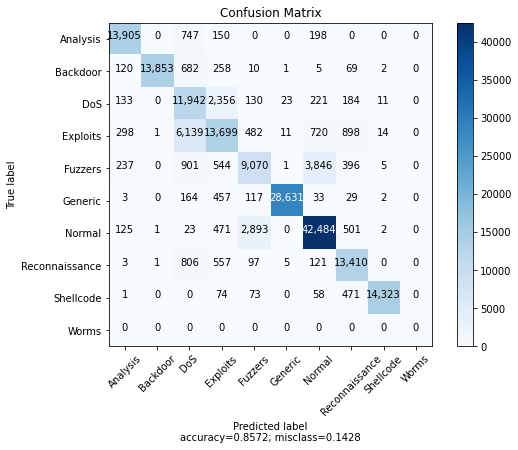

In [97]:
plot_confusion_matrix(cm           = confussion_matrix, 
                      normalize    = False,
                      target_names = ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic','Normal', 'Reconnaissance', 'Shellcode', 'Worms'],
                      title        = "Confusion Matrix")

In [98]:
target_class=[]
target_class=["Analysis","Backdoor","DoS", "Exploits", "Fuzzers", "Generic","Normal","Reconnaissance", "Shellcode", "Worms"]

In [99]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

In [100]:
pred1 = model.predict(x_test_2)

In [101]:
dummies = pd.get_dummies(train_y_over) # Classification

print (dummies)
outcomes = dummies.columns
num_classes = len(outcomes)
y_train_1 = dummies.values

        Analysis  Backdoor  DoS  Exploits  Fuzzers  Generic  Normal  \
0              0         0    0         0        0        0       1   
1              0         0    0         0        0        0       1   
2              0         0    0         0        0        0       1   
3              0         0    0         0        0        0       1   
4              0         0    0         0        0        0       1   
...          ...       ...  ...       ...      ...      ...     ...   
219693         1         0    0         0        0        0       0   
219694         1         0    0         0        0        0       0   
219695         1         0    0         0        0        0       0   
219696         1         0    0         0        0        0       0   
219697         1         0    0         0        0        0       0   

        Reconnaissance  Shellcode  
0                    0          0  
1                    0          0  
2                    0          0  
3  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


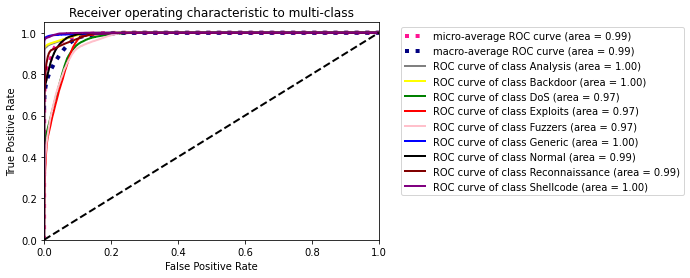

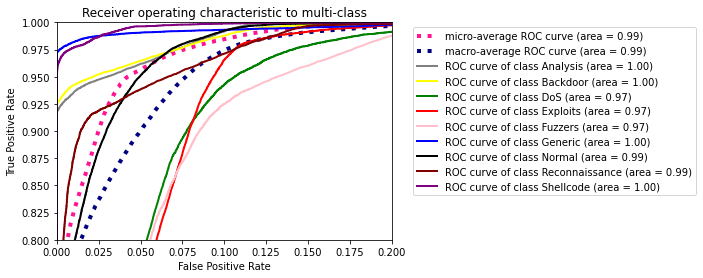

In [102]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(9):
    fpr[i], tpr[i], _ = roc_curve(y_test_2[:, i], pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_2.ravel(), pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(9)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(9):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 9

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['grey', 'yellow', 'green','red','pink','blue','black','maroon','purple','orange'])
for i, color in zip(range(9), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

#zoom in the plot
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['grey', 'yellow', 'green','red','pink','blue','black','maroon','purple','orange'])
for i, color in zip(range(9), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [103]:
import random

classes = {0: "Analysis", 1: "Backdoor", 2: "DoS", 3: "Exploits", 4: "Fuzzers", 
           5: "Generic", 6: "Normal", 7: "Reconnaissance", 8: "Shellcode"}
random_sample = new_train_df.sample()
print(random_sample["Class"])
random_sample_train = random_sample
random_sample_train = random_sample_train.drop("Class", axis = 1)

pred = model.predict(random_sample_train)
print(pred)
print(classes[np.argmax(pred, axis=1)[0]])

62923    Fuzzers
Name: Class, dtype: object
[[2.1724941e-04 9.9523808e-05 2.6640075e-03 6.3310526e-03 5.1541460e-01
  6.6324847e-04 4.7393817e-01 4.0001274e-04 2.7213950e-04]]
Fuzzers


In [104]:
model.save_weights("project_1.3.h5")